In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_gr()
working_dir = fs.WORKING_DIR_GR
pst_name = fs.PST_NAME_GR

['botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_gr
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_kl_demo/freyberg_gr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FIN

In [3]:
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)

In [15]:
v = pyemu.geostats.ExpVario(1.0,a=200,anisotropy=10.0,bearing=45)
struct = pyemu.geostats.GeoStruct(variograms=v)
arr_dict = {"test":np.ones((m.nrow,m.ncol))}

In [16]:
bd = pyemu.helpers.kl_setup(num_eig=800,sr=m.sr,struct=struct,array_dict=arr_dict,basis_file="basis.jco")

In [17]:
basis = pyemu.Matrix.from_binary("basis.jco").to_dataframe().T

In [18]:
i = basis.index.map(lambda x: int(x[1:5]))
j = basis.index.map(lambda x: int(x[-4:]))

In [19]:
def plot_eig_arr(eig):
    arr = np.zeros((m.nrow,m.ncol))
    arr[i,j] = basis.iloc[:,eig]
    mm = flopy.plot.ModelMap(model=m)
    mm.plot_array(arr)
    mm.plot_ibound()
    #mm = plt.imshow(arr)
    return mm

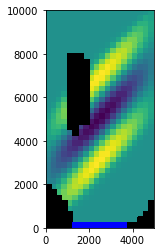

In [20]:
mm = plot_eig_arr(2)

In [21]:
#interact(plot_eig_arr, eig=widgets.IntSlider(min=0,max=799,step=1,value=10));
interact(plot_eig_arr, eig=widgets.IntText(description="eig comp", continuous_update=True));

interactive(children=(IntText(value=0, continuous_update=True, description='eig comp'), Output()), _dom_classes=('widget-interact',))

### Now lets look at how the KL reconstruction looks for a nasty zone array...

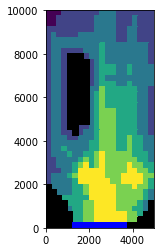

In [11]:
arr = np.loadtxt(os.path.join("..","..","models","Freyberg","Freyberg_Truth","hk.zones"))
mm = flopy.plot.ModelMap(model=m)
mm.plot_array(arr)
mm.plot_ibound()

In [12]:
basis_arr = np.array(basis.values)
flat_arr = np.atleast_2d(arr.flatten()).transpose()

In [13]:
def plot_eig_arr(eig):
    basis_eig = basis_arr[:,:eig+1].transpose()
    factors = np.dot(basis_eig,flat_arr).transpose()
    factors = np.dot(factors,basis_eig).reshape(arr.shape)
    mm = flopy.plot.ModelMap(model=m)
    mm.plot_array(factors)
    mm.plot_ibound()
    return mm

In [14]:
interact(plot_eig_arr, eig=widgets.IntText(description="eig comp", continuous_update=True));

interactive(children=(IntText(value=0, continuous_update=True, description='eig comp'), Output()), _dom_classes=('widget-interact',))